In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src import layer, losses
from src.model import Model

In [2]:
data_df = pd.read_csv('ionosphere_data.csv', header=None)

data_df['is_good'] = data_df[34].apply(lambda x: 1 if x == 'g' else 0)
data_df = data_df.drop(34, axis=1)

data_df


,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,is_good
0,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,1,0,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,...,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,1
347,1,0,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,...,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,1
348,1,0,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,...,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,1
349,1,0,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,...,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,1


In [3]:
dataset = np.array(data_df)
np.random.shuffle(dataset)

train_ratio = 0.8
train_size = int(len(dataset) * train_ratio)

train_feature = dataset[:train_size, :-1]
test_feature = dataset[train_size:, :-1]
train_target = dataset[:train_size, -1:]
test_target = dataset[train_size:, -1:]

In [4]:
def split_batch(x, y, batch_size):
    for i in range(0, len(x), batch_size):
        if i + batch_size < len(x):
            yield x[i:i + batch_size], y[i:i + batch_size]
        yield x[i:], y[i:]

In [5]:
INPUT_FEATURES = train_feature.shape[1]

model = Model([
    layer.Linear(INPUT_FEATURES, 8),
    layer.ReLU(),
    layer.Linear(8, 1),
    layer.Sigmoid(),
])

bce = losses.BinaryCrossEntropy()

In [6]:
EPOCHES = 1000
BATCH_SIZE = 128

train_losses = []
for epoch in range(EPOCHES):

    losses = []
    for x, y in split_batch(train_feature, train_target, BATCH_SIZE):
        y_pred = model(x)
        losses.append(bce(y_pred, y))
        grad = bce.backward()
        model.backward(grad)
        model.update(0.001)

    train_losses.append(np.mean(losses))

    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch}: {np.mean(losses)}')

Epoch 99: 1.0995283164910021
Epoch 199: 0.8202287105314199
Epoch 299: 0.6573820488316273
Epoch 399: 0.5596439673897489
Epoch 499: 0.49879861002952824
Epoch 599: 0.45793037016356647
Epoch 699: 0.42772368956115925
Epoch 799: 0.40481274049655686
Epoch 899: 0.3877630398958033
Epoch 999: 0.37570853464204357


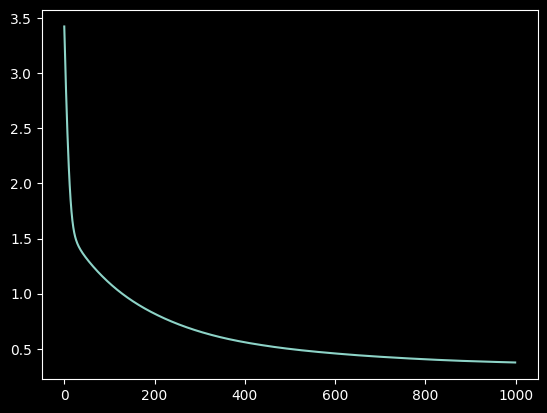

In [7]:
plt.plot(train_losses)

In [8]:
y_pred = model(test_feature)
print(bce(y_pred, test_target))

0.34628016757014757


In [9]:
pd.DataFrame(np.concatenate([y_pred, test_target], axis=1))

,0,1
0,0.535493,1.0
1,0.949438,1.0
2,0.826146,1.0
3,0.631258,1.0
4,0.001644,0.0
...,...,...
66,0.917713,1.0
67,0.296018,0.0
68,0.954686,1.0
69,0.940846,1.0
